In [1]:
#LOADING REQUIRED LIBRARIES
#Data Visualization libraries
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

#Encoders
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Importing train, test split library
from sklearn.model_selection import train_test_split

#Metrices import
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, roc_curve, make_scorer
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_selection import SelectFromModel
from numpy import sort

#Accuracy Check
from sklearn.model_selection import cross_val_score

#Importing custom packages
from sklearn.base import TransformerMixin

# Importing ML Model packages
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
#from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Hyperopt
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope

#For proper display of all columns
from IPython.display import display
pd.options.display.max_columns = None

#Import warnings
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm


In [2]:
data_raw = pd.read_csv("compas-scores-two-years.csv")

In [3]:
data_raw.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,14-08-2013,Male,18-04-1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13-08-2013 6.03,14-08-2013 5.41,13011352CF10A,13-08-2013,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,14-08-2013,Risk of Violence,1,Low,14-08-2013,07-07-2014,14-07-2014,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,27-01-2013,Male,22-01-1982,34,25 - 45,African-American,0,3,0,0,0,-1.0,26-01-2013 3.45,05-02-2013 5.36,13001275CF10A,26-01-2013,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,05-07-2013,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),05-07-2013,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,27-01-2013,Risk of Violence,1,Low,27-01-2013,26-01-2013,05-02-2013,0,9,159,1,1
2,4,ed philo,ed,philo,14-04-2013,Male,14-05-1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13-04-2013 4.58,14-04-2013 7.02,13005330CF10A,13-04-2013,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,16-06-2013,Driving Under The Influence,16-06-2013,16-06-2013,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,14-04-2013,Risk of Violence,3,Low,14-04-2013,16-06-2013,16-06-2013,4,0,63,0,1
3,5,marcu brown,marcu,brown,13-01-2013,Male,21-01-1993,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,12-01-2013,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,13-01-2013,Risk of Violence,6,Medium,13-01-2013,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,26-03-2013,Male,22-01-1973,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,09-01-2013,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,26-03-2013,Risk of Violence,1,Low,26-03-2013,NaN,NaN,2,0,1102,0,0


In [4]:
def calculate_count_and_proportion_per_label(df, target_variable):
  """Calculates the count and proportion per label in a Pandas DataFrame with a binary target variable.

  Args:
    df: A Pandas DataFrame.
    target_variable: The name of the binary target variable in the DataFrame.

  Returns:
    A Pandas Series containing the count and proportion per label.
  """

  # Create a new Series containing the count per label.
  count_per_label = df[target_variable].value_counts()

  # Calculate the proportion per label.
  proportion_per_label = count_per_label / count_per_label.sum()

  # Return the Series containing the count and proportion per label.
  return pd.DataFrame({'count_per_label':count_per_label,'proportion_per_label':proportion_per_label})

# Calculate the count and proportion per label in the DataFrame.
df = calculate_count_and_proportion_per_label(data_raw, 'two_year_recid')

# Print the count and proportion per label.
print(df)


   count_per_label  proportion_per_label
0             3963              0.549348
1             3251              0.450652


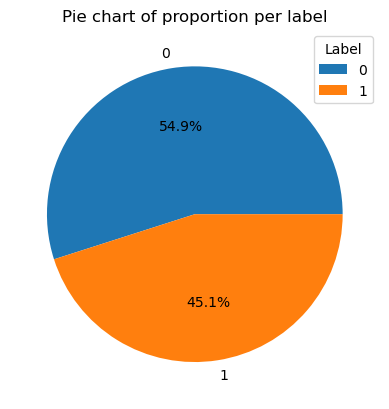

In [5]:
plt.pie(x=df['proportion_per_label'], labels=df.index,autopct='%1.1f%%')
# Add a legend to the pie chart.
plt.legend(df.index.to_numpy(), title='Label')
plt.title('Pie chart of proportion per label')
plt.show()

55% people reoffended

In [6]:
#count the proportion of those who reoffended and those who didnt
data_raw['two_year_recid'].value_counts()

0    3963
1    3251
Name: two_year_recid, dtype: int64

In [7]:
data_raw[data_raw['r_charge_desc'].isnull()]['two_year_recid'].value_counts()

0    3765
1      36
Name: two_year_recid, dtype: int64

| Column Name             | Description                                                                                   |
|-------------------------|-----------------------------------------------------------------------------------------------|
| id                      | A unique identifier for each individual in the dataset.                                   |
| name                    | The individual's name (may or may not be anonymized).                                      |
| first                   | The individual's first name.                                                                 |
| last                    | The individual's last name.                                                                  |
| compas_screening_date    | The date when the individual was screened using the COMPAS assessment tool.               |
| sex                     | The gender of the individual.                                                               |
| dob                     | Date of birth of the individual.                                                            |
| age                     | The age of the individual.                                                                  |
| age_cat                 | A categorical variable indicating the age group of the individual (e.g., "18-30," "31-40," etc.). |
| race                    | The race or ethnicity of the individual.                                                   |
| juv_fel_count           | The count of prior juvenile felony offenses.                                               |
| decile_score            | The COMPAS risk score, which is used to predict the likelihood of recidivism.               |
| juv_misd_count          | The count of prior juvenile misdemeanor offenses.                                          |
| juv_other_count         | The count of other prior juvenile offenses.                                                |
| priors_count            | The total count of prior criminal offenses (including both juvenile and adult offenses).   |
| days_b_screening_arrest | The number of days between screening and the arrest event.                                  |
| c_jail_in               | Date and time when the individual was admitted to jail.                                    |
| c_jail_out              | Date and time when the individual was released from jail.                                  |
| c_case_number           | A case number associated with the arrest event.                                            |
| c_offense_date          | The date of the offense that led to the arrest.                                            |
| c_arrest_date           | The date of the individual's arrest.                                                       |
| c_days_from_compas      | The number of days between the COMPAS screening and the arrest event.                      |
| c_charge_degree         | The degree of the criminal charge (e.g., misdemeanor or felony).                             |
| c_charge_desc           | A description of the criminal charge.                                                       |
| is_recid               | A binary variable indicating whether the individual is a recidivist (reoffender).          |
| r_case_number           | A case number associated with the recidivism event.                                        |
| r_charge_degree         | The degree of the criminal charge for the recidivism event.                                 |
| r_days_from_arrest      | The number of days between the individual's arrest and the recidivism event.               |
| r_offense_date          | The date of the recidivism offense.                                                        |
| r_charge_desc           | A description of the recidivism charge.                                                    |
| r_jail_in               | Date and time when the individual was admitted to jail for the recidivism event.          |
| r_jail_out              | Date and time when the individual was released from jail for the recidivism event.        |
| violent_recid           | A binary variable indicating whether the recidivism event was violent.                    |
| is_violent_recid        | A binary variable indicating whether the recidivism event is violent.                      |
| vr_case_number          | A case number associated with the violent recidivism event.                                 |
| vr_charge_degree        | The degree of the criminal charge for the violent recidivism event.                         |
| vr_offense_date         | The date of the violent recidivism offense.                                                |
| vr_charge_desc          | A description of the violent recidivism charge.                                            |
| type_of_assessment      | The type of COMPAS assessment used.                                                        |
| score_text              | A text representation of the COMPAS risk score.                                            |
| screening_date          | The date of the COMPAS screening.                                                           |
| v_type_of_assessment    | The type of assessment for violent recidivism.                                             |
| v_decile_score          | The risk score for violent recidivism.                                                     |
| v_score_text            | A text representation of the violent recidivism risk score.                                 |
| v_screening_date        | The date of the violent recidivism assessment.                                            |
| in_custody              | Date and time when the individual was in custody.                                         |
| out_custody             | Date and time when the individual was released from custody.                               |
| priors_count (again)    | The total count of prior criminal offenses (repeated from an earlier column).              |
| start                   | A date indicating the start of a specific period or event.                                  |
| end                     | A date indicating the end of a specific period or event.                                    |
| event                   | An event related to the criminal justice process.                                          |
| two_year_recid          | A binary variable indicating whether the individual recidivated within two years.          |


- Check: Source of v_decile_score??

In [8]:
data_raw.describe()

,id,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,r_days_from_arrest,violent_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,start,end,event,two_year_recid
count,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,6907.000000,7192.000000,7214.000000,2316.000000,0.0,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000
mean,5501.255753,34.817993,0.067230,4.509565,0.090934,0.109371,3.472415,3.304763,57.731368,0.481148,20.269430,NaN,0.113529,4.509565,3.691849,3.472415,11.465068,553.436651,0.382867,0.450652
std,3175.706870,11.888922,0.473972,2.856396,0.485239,0.501586,4.882538,75.809505,329.740215,0.499679,74.871668,NaN,0.317261,2.856396,2.510148,4.882538,46.954563,399.020583,0.486120,0.497593
min,1.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-414.000000,0.000000,0.000000,-1.000000,NaN,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2735.250000,25.000000,0.000000,2.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,2.000000,1.000000,0.000000,0.000000,148.250000,0.000000,0.000000
50%,5509.500000,31.000000,0.000000,4.000000,0.000000,0.000000,2.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,4.000000,3.000000,2.000000,0.000000,530.500000,0.000000,0.000000
75%,8246.500000,42.000000,0.000000,7.000000,0.000000,0.000000,5.000000,0.000000,2.000000,1.000000,1.000000,NaN,0.000000,7.000000,5.000000,5.000000,1.000000,914.000000,1.000000,1.000000
max,11001.000000,96.000000,20.000000,10.000000,13.000000,17.000000,38.000000,1057.000000,9485.000000,1.000000,993.000000,NaN,1.000000,10.000000,10.000000,38.000000,937.000000,1186.000000,1.000000,1.000000


In [9]:
data_raw.describe(include = ['O'])

,name,first,last,compas_screening_date,sex,dob,age_cat,race,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,r_case_number,r_charge_degree,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,score_text,screening_date,v_type_of_assessment,v_score_text,v_screening_date,in_custody,out_custody
count,7214,7214,7214,7214,7214,7214,7214,7214,6907,6907,7192,6055,1137,7214,7185,3471,3471,3471,3413,2316,2316,819,819,819,819,7214,7214,7214,7214,7214,7214,6978,6978
unique,7158,2800,3950,690,2,5452,3,6,6848,6196,7192,927,580,2,437,3471,10,1075,340,972,938,819,9,570,83,1,3,690,1,3,690,1156,1169
top,anthony smith,michael,williams,20-02-2013,Male,21-12-1987,25 - 45,African-American,06-10-2014 7.50,30-04-2013 7.29,13011352CF10A,14-01-2013,06-02-2013,F,Battery,13009779CF10A,(M1),08-12-2014,Driving License Suspended,27-05-2014,15-05-2015,13009779CF10A,(M1),15-08-2015,Battery,Risk of Recidivism,Low,20-02-2013,Risk of Violence,Low,20-02-2013,04-01-2014,01-01-2020
freq,3,149,83,32,5819,5,4109,3696,2,6,1,26,9,4666,1156,1,1201,12,258,9,9,1,344,6,329,7214,3897,32,7214,4761,32,20,61


In [10]:
data_raw.shape

(7214, 53)

In [11]:
# Funtion to check the missing value count and percentage
def missing_val_check(data):
    """
    Input::data - A pandas dataframe
    Output::Missing value report by column
    """
    # Missing data check
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat(
        [total, percent * 100], axis=1, keys=["Total", "Percent(%)"]
    )
    return missing_data

In [12]:
miss_data = missing_val_check(data_raw)
miss_data.head(25)

,Total,Percent(%)
violent_recid,7214,100.000000
vr_charge_degree,6395,88.647075
vr_case_number,6395,88.647075
vr_offense_date,6395,88.647075
vr_charge_desc,6395,88.647075
c_arrest_date,6077,84.238980
r_jail_out,4898,67.895758
r_jail_in,4898,67.895758
r_days_from_arrest,4898,67.895758
r_charge_desc,3801,52.689215


In [13]:
miss_data.index

Index(['violent_recid', 'vr_charge_degree', 'vr_case_number',
       'vr_offense_date', 'vr_charge_desc', 'c_arrest_date', 'r_jail_out',
       'r_jail_in', 'r_days_from_arrest', 'r_charge_desc', 'r_offense_date',
       'r_case_number', 'r_charge_degree', 'c_offense_date', 'c_jail_out',
       'days_b_screening_arrest', 'c_jail_in', 'out_custody', 'in_custody',
       'c_charge_desc', 'c_days_from_compas', 'c_case_number',
       'v_type_of_assessment', 'type_of_assessment', 'decile_score.1',
       'v_decile_score', 'v_score_text', 'v_screening_date', 'screening_date',
       'priors_count.1', 'start', 'end', 'event', 'score_text', 'id',
       'is_violent_recid', 'name', 'first', 'last', 'compas_screening_date',
       'sex', 'dob', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree',
       'is_recid', 'two_year_recid'],
      dtype='object')

In [14]:
data_raw[(data_raw['c_charge_desc'].isnull()) & (data_raw['c_days_from_compas']).isnull()].shape

(22, 53)

# Data Cleaning

**Data Treatment on missing data**

- violent_recid = Dropping this since entire data missing
- vr_charge_degree, vr_case_number, vr_offense_date, vr_charge_desc,
  c_arrest_date, 'r_jail_out', 'r_jail_in', 'r_days_from_arrest', 'r_charge_desc', 'r_offense_date', 'r_case_number', 'r_charge_degree' =
Dropping these since > 50% data missing. Imputation might led to false information
- c_offense_date :
- c_jail_out :
- days_b_screening_arrest :
- c_jail_in :
- out_custody :
- in_custody : drop data where values are null since less than 1% data missing
- c_charge_desc : drop data where values are null since less than 1% data missing
- c_days_from_compas : No treatment since not useful feature
- c_case_number : No treatment since not useful feature
- v_type_of_assessment: Drop this since only single value present

In [15]:
#creating the copy of raw df for further processing
data = data_raw.copy()

Checking the seriousness of the crimes in the dataset

In [16]:
#mkaing values more intuituve
data['c_charge_degree'][data['c_charge_degree'] == 'F'] = 'Felony'
data['c_charge_degree'][data['c_charge_degree'] == 'M'] = 'Misdemeanor'

In [17]:
#checking the seriousness of the crimes in the dataset
charge_degree_counts = data['c_charge_degree'].value_counts()

# Calculate the proportion per label.
charge_dergree_proportion = charge_degree_counts / charge_degree_counts.sum()

  # Return the Series containing the count and proportion per label.
pd.DataFrame({'count_per_label':charge_degree_counts,'proportion_per_label':charge_dergree_proportion})

,count_per_label,proportion_per_label
Felony,4666,0.646798
Misdemeanor,2548,0.353202


65% serious crimes

In [18]:
# Drop cols
#calcualating the time in custody and dropping the custody date columns
data['time_in_custody_in_days'] = pd.to_datetime(data['out_custody']) - pd.to_datetime(data['in_custody'])
data['time_in_custody_in_days'] = data['time_in_custody_in_days'].dt.days
data['time_in_custody_in_days'] = data['time_in_custody_in_days'].fillna(0)

#calcualating the time in jail and dropping the jail date columns
data['time_in_jail_in_days'] = pd.to_datetime(data['c_jail_out'],format='%d-%m-%Y %H.%M') - pd.to_datetime(data['c_jail_in'],format='%d-%m-%Y %H.%M')
data['time_in_jail_in_days'] = data['time_in_jail_in_days'].dt.days
data['time_in_jail_in_days'] = data['time_in_jail_in_days'].fillna(0)
data['time_in_jail_in_days'][data['time_in_jail_in_days'] < 0] = 0
drop_lst1 = ['violent_recid', 'vr_charge_degree', 'vr_case_number',
            'vr_offense_date', 'vr_charge_desc', 'c_arrest_date', 'r_jail_out',
            'r_jail_in', 'r_days_from_arrest', 'r_charge_desc', 'r_offense_date',
            'r_case_number', 'r_charge_degree', 'c_offense_date', 'c_jail_out',
            'days_b_screening_arrest', 'c_jail_in', 'out_custody', 'in_custody']

# priors_count.1 has exactly same descriptive stats like priors_count
drop_lst2 = ['name', 'first', 'last', 'compas_screening_date',
             'dob', 'c_case_number', 'priors_count.1','decile_score.1', 'start',
             'end', 'v_screening_date', 'screening_date', 'type_of_assessment',
             'c_days_from_compas', 'decile_score', 'v_decile_score',
             'v_type_of_assessment', 'is_recid', 'event', 'is_violent_recid']
drop_lst = drop_lst1 + drop_lst2
data.drop(drop_lst, axis = 1, inplace = True)

# Drop data where c_charge_desc is missing
#data = data[~data['c_charge_desc'].isnull()]

In [19]:
data = data[~data['c_charge_desc'].isnull()]

# EDA

In [20]:
data.head()

,id,sex,age,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,score_text,v_score_text,two_year_recid,time_in_custody_in_days,time_in_jail_in_days
0,1,Male,69,Greater than 45,Other,0,0,0,0,Felony,Aggravated Assault w/Firearm,Low,Low,0,7.0,0.0
1,3,Male,34,25 - 45,African-American,0,0,0,0,Felony,Felony Battery w/Prior Convict,Low,Low,1,96.0,10.0
2,4,Male,24,Less than 25,African-American,0,0,1,4,Felony,Possession of Cocaine,Low,Low,1,0.0,1.0
3,5,Male,23,Less than 25,African-American,0,1,0,1,Felony,Possession of Cannabis,High,Medium,0,0.0,0.0
4,6,Male,43,25 - 45,Other,0,0,0,2,Felony,arrest case no charge,Low,Low,0,0.0,0.0


In [21]:
data.describe(include = ['O'])

,sex,age_cat,race,c_charge_degree,c_charge_desc,score_text,v_score_text
count,7185,7185,7185,7185,7185,7185,7185
unique,2,3,6,2,437,3,3
top,Male,25 - 45,African-American,Felony,Battery,Low,Low
freq,5798,4095,3684,4660,1156,3876,4738


<AxesSubplot:xlabel='age', ylabel='Density'>

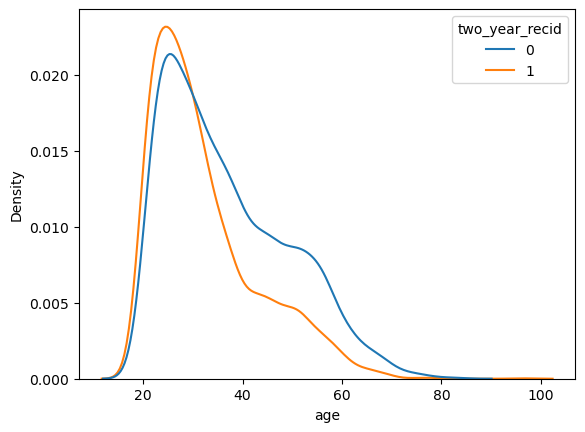

In [22]:
cont_cols = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'time_in_custody_in_days','time_in_jail_in_days']
sns.kdeplot(data=data, x = data['age'],hue=data['two_year_recid'],common_norm=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


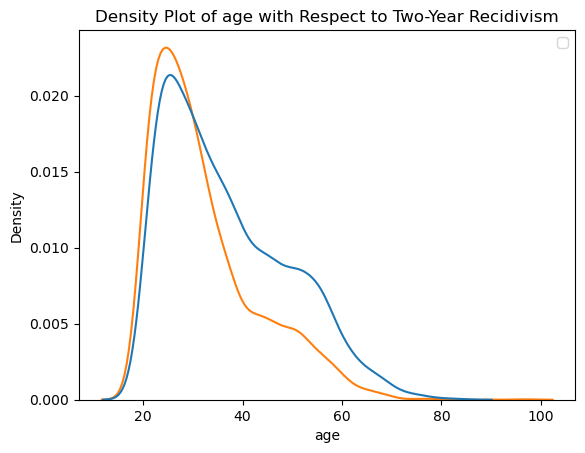

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


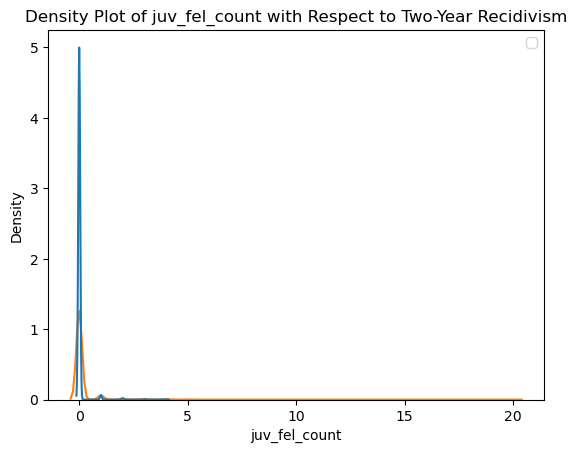

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


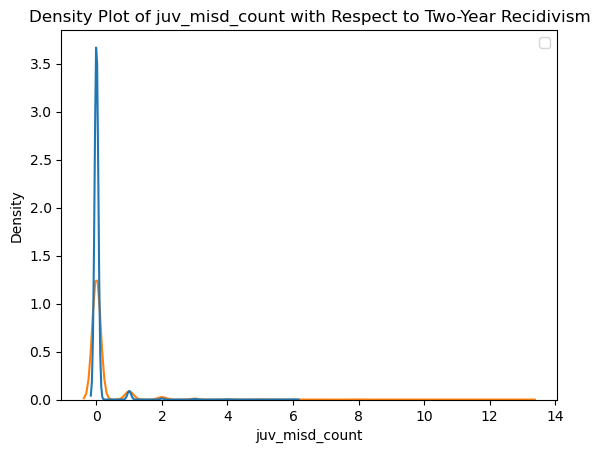

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


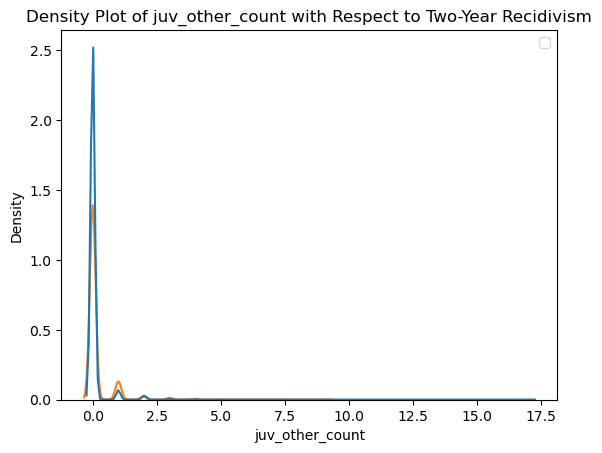

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


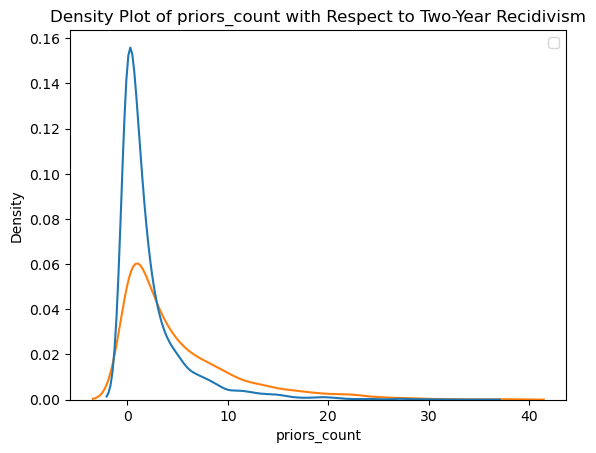

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


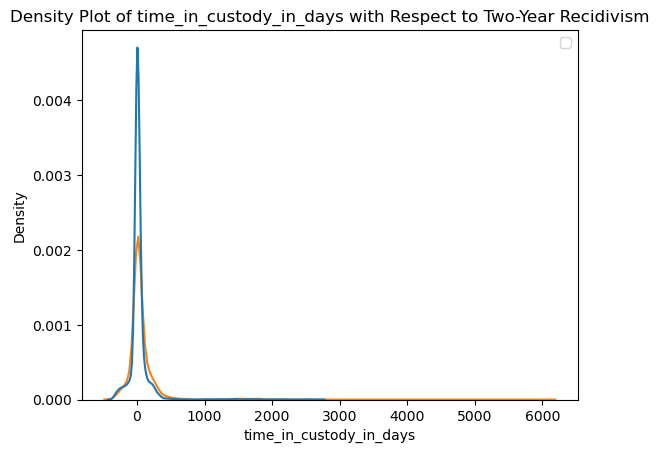

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


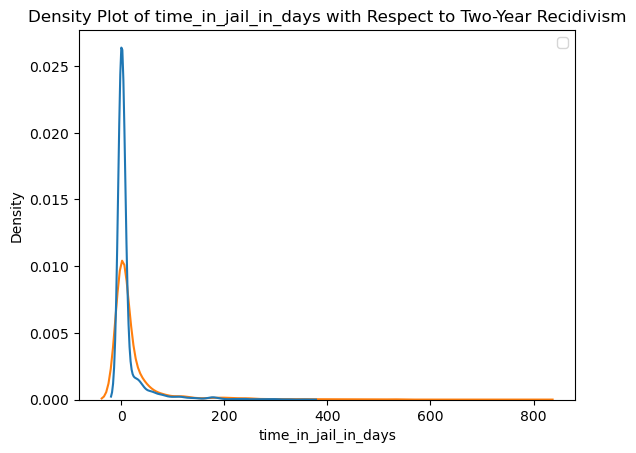

In [23]:
# Create a list of the continuous columns
cont_cols = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'time_in_custody_in_days','time_in_jail_in_days']

# Iterate over the continuous columns and plot density plots
for col in cont_cols:
    sns.kdeplot(data=data, x=data[col], hue=data['two_year_recid'], common_norm=True)
    plt.title(f'Density Plot of {col} with Respect to Two-Year Recidivism')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [24]:
# cont_cols = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'time_in_custody_in_days','time_in_jail_in_days']

# # Create the 3x2 grid of subplots
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 8))

# # Iterate over the cols list and create a density plot for each value
# for i, j in enumerate(cont_cols):
#     row = i // 3
#     col = i % 2
#     ax = axes[row, col]
#     sns.kdeplot(data=data, x=j, hue='two_year_recid', ax=ax)

#     # Set the title and labels for each plot
#     ax.set_title(f'Density Plot of {j} vs Two year recidivism')
#     ax.set_xlabel(col)
#     ax.set_ylabel('Density')

# # Adjust the layout and show the plot
# plt.tight_layout()
# plt.show()

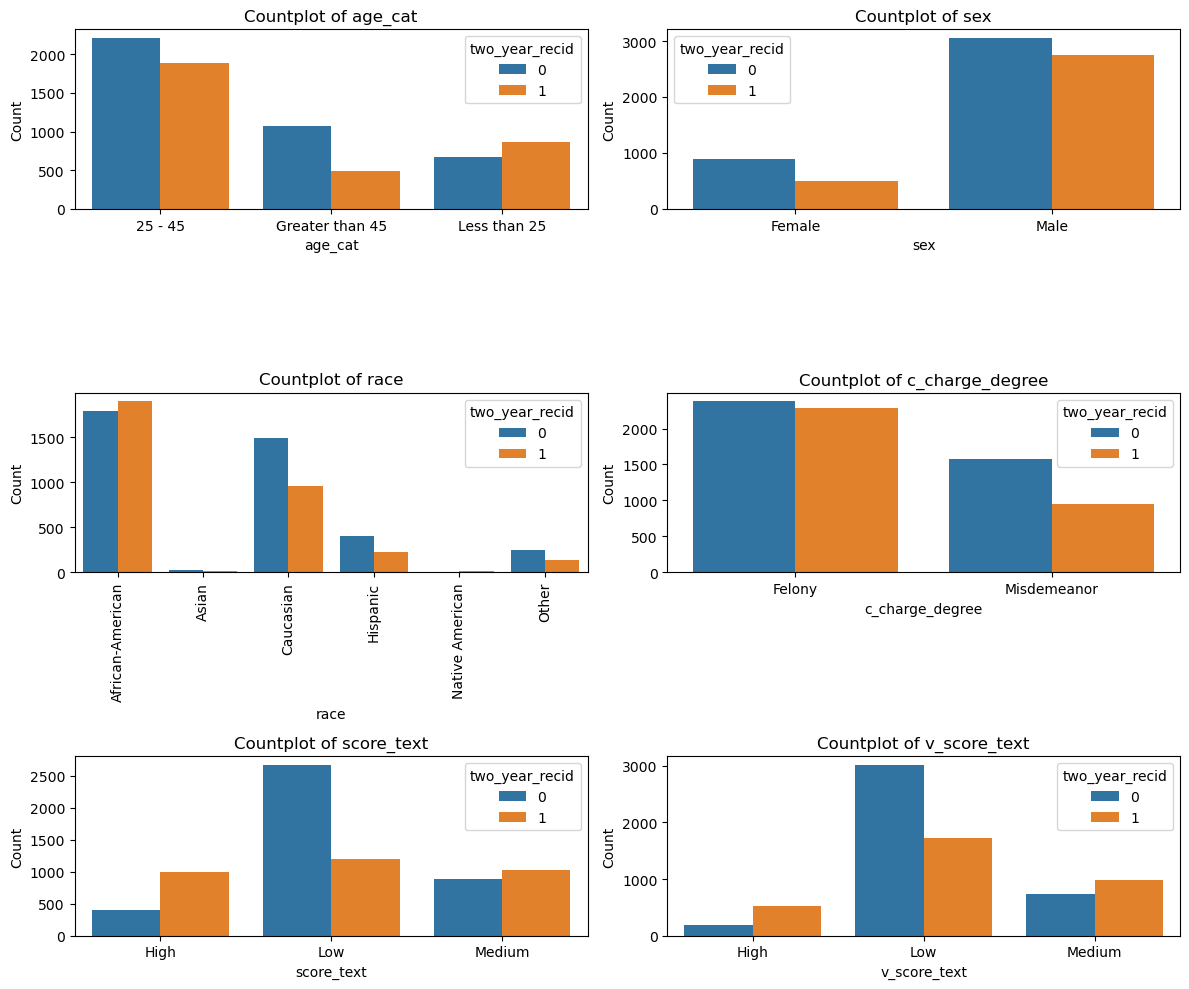

In [25]:
# List of categorical columns to plot
cat_cols = ['age_cat', 'sex', 'race', 'c_charge_degree', 'score_text', 'v_score_text']

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Plot count plots for each categorical column
for i, col in enumerate(cat_cols):
    order = sorted(data[col].unique())
    sns.countplot(data=data, x=col, ax=axes[i], hue = 'two_year_recid', order = order)
    axes[i].set_title(f'Countplot of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

    if col=='race':
      # Rotate x-axis labels vertically
      axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)  # Adjust the rotation angle as needed

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [26]:
data.head()

,id,sex,age,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,score_text,v_score_text,two_year_recid,time_in_custody_in_days,time_in_jail_in_days
0,1,Male,69,Greater than 45,Other,0,0,0,0,Felony,Aggravated Assault w/Firearm,Low,Low,0,7.0,0.0
1,3,Male,34,25 - 45,African-American,0,0,0,0,Felony,Felony Battery w/Prior Convict,Low,Low,1,96.0,10.0
2,4,Male,24,Less than 25,African-American,0,0,1,4,Felony,Possession of Cocaine,Low,Low,1,0.0,1.0
3,5,Male,23,Less than 25,African-American,0,1,0,1,Felony,Possession of Cannabis,High,Medium,0,0.0,0.0
4,6,Male,43,25 - 45,Other,0,0,0,2,Felony,arrest case no charge,Low,Low,0,0.0,0.0


In [27]:
data_baseline = data.copy()

# Modelling Data Prep

In [28]:
def onehotdataframe(data, cat_cols):
    """
    Creates dummy features for categorical data.
    """
    for c in cat_cols:
        one_hot_col = pd.get_dummies(data[c])
        one_hot_col.columns = [str(col) + "_" + c for col in one_hot_col.columns]
        data = data.drop(c, axis=1)

        # Merging one hot encoded features with our dataset 'data'
        data = pd.concat([data, one_hot_col], axis=1)

    return data

In [29]:
# label encoding Sex
data_baseline['sex'] = data_baseline['sex'].replace({'Male' : 1, 'Female' : 0})

# Apply One hot
cat_cols = ['race', 'c_charge_degree', 'score_text', 'v_score_text']
data_baseline = onehotdataframe(data_baseline, cat_cols)

# Apply Target Encoding
target_encoding_col = ['c_charge_desc']
target_encodings = {}

# Define the noise level to avoid overfitting and leakage
noise_level = 0.01

# Loop through each categorical column
for column in target_encoding_col:
    # Calculate the mean target value for each category
    encoding_map = data_baseline.groupby(column)['two_year_recid'].mean().to_dict()

    # Add noise to the encoding
    for key in encoding_map:
        encoding_map[key] += np.random.uniform(-noise_level, noise_level)

    # Map the category to its target encoding
    data_baseline[column] = data_baseline[column].map(encoding_map)

    # Store the encoding map for future use (e.g., applying the same encoding to test data)
    target_encodings[column] = encoding_map

In [30]:
# Creating a copy for mapping data for predictions
data_cp = data_baseline.copy()

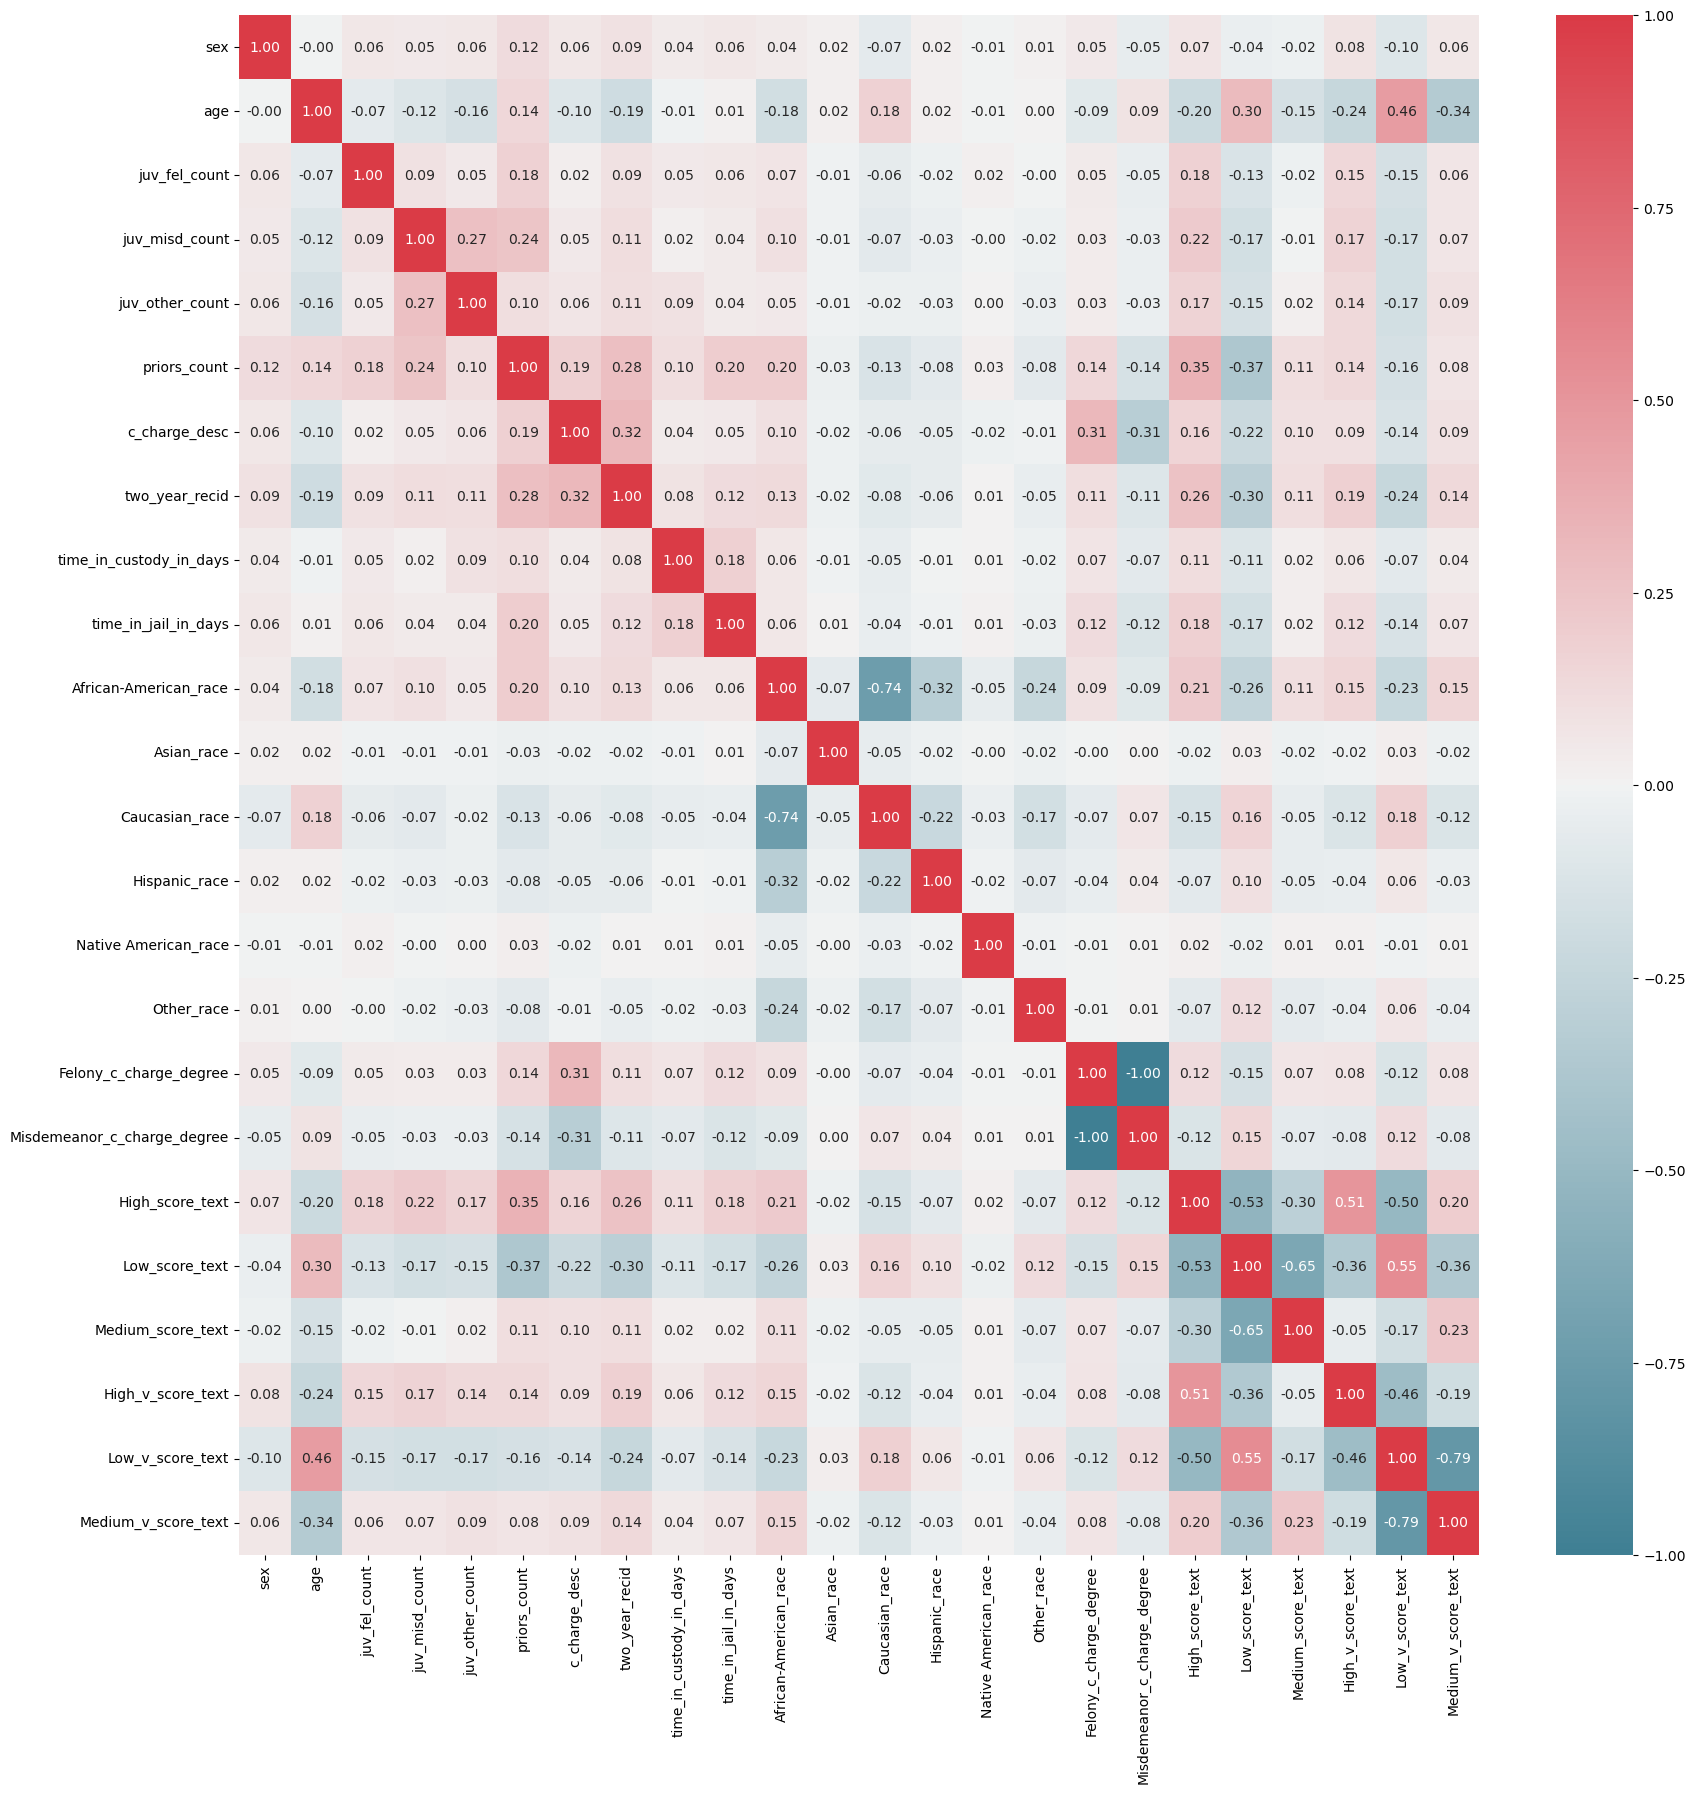

In [31]:
# Printing correlation matrix
plt.figure(figsize=(20, 20))

# Get the correlation matrix
corr = data_baseline.drop(['id', 'age_cat'], axis = 1).corr()

# Define a custom colormap with distinct colors for positive and negative correlations
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot the correlation heatmap with the custom colormap and colorbar legend
sns.heatmap(corr, annot=True, cmap=cmap, cbar=True, fmt=".2f")

# Display the plot
plt.show()

# Train Test Split

In [32]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_baseline.drop(['age_cat', 'two_year_recid'], axis = 1), data_baseline['two_year_recid'], test_size=0.2, random_state=1000, stratify = data_baseline['two_year_recid'])
#y_train.reset_index(drop = True, inplace = True)
#y_test.reset_index(drop = True, inplace = True)

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the training data using the scaler
X_train_scaled = scaler.fit_transform(X_train.drop(['id'], axis = 1))
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.drop(['id'], axis = 1).columns, index = X_train.index)

# Transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test.drop(['id'], axis = 1))
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_train.drop(['id'], axis = 1).columns, index = X_test.index)

# Model

In [33]:
# building the model and fitting the data
log_reg = sm.Logit(y_train, X_train_scaled).fit()
#results = log_reg.fit()

         Current function value: 0.568420
         Iterations: 35


c:\Users\athar\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
# printing the summary table
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:         two_year_recid   No. Observations:                 5748
Model:                          Logit   Df Residuals:                     5729
Method:                           MLE   Df Model:                           18
Date:                Thu, 16 Nov 2023   Pseudo R-squ.:                  0.1740
Time:                        14:18:23   Log-Likelihood:                -3267.3
converged:                      False   LL-Null:                       -3955.7
Covariance Type:            nonrobust   LLR p-value:                1.328e-281
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
sex                             0.1039      0.030      3.417      0.001       0.044       0.164
age                            -0.3933      0.038    -10.274      0.000      -0.

Classification Report for Logistic Regression model on test set

              precision    recall  f1-score   support

           0       0.73      0.72      0.72       790
           1       0.66      0.67      0.66       647

    accuracy                           0.70      1437
   macro avg       0.69      0.69      0.69      1437
weighted avg       0.70      0.70      0.70      1437


 accuracy: 0.6958942240779401 & F1_Score: 0.6932266673440763 



<AxesSubplot:>

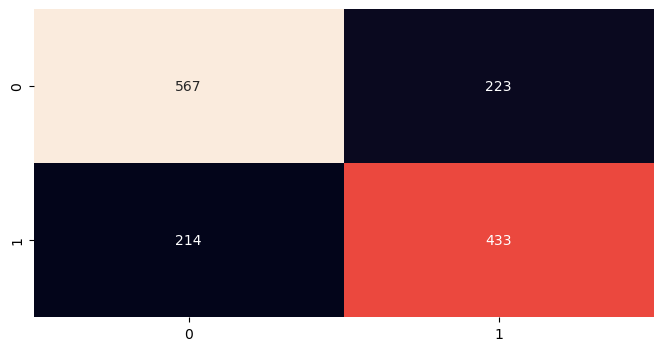

In [35]:
# Performance on test
model_name = 'Logistic Regression'
y_pred_prob = log_reg.predict(X_test_scaled)
y_pred_test = (y_pred_prob >= 0.5).astype(int)
print(
    "Classification Report for {} model on test set\n".format(model_name)
)
print(classification_report(y_test, y_pred_test))
print(
    "\n accuracy: {} & F1_Score: {} \n".format(
        accuracy_score(y_test, y_pred_test),
        f1_score(y_test, y_pred_test, average="macro"),
    )
)
cm_val = confusion_matrix(y_test, y_pred_test)

plt.subplots(figsize=(8, 4))
sns.heatmap(cm_val, annot=True, fmt="d", cbar=False)

Observations: Our Accuracy is 70% and Recall is 67%. 
We will keep recall and f1 score as our performance metric. Recall tells us that out of people who actually committed reoffence, how many were actually predicted to reoffend. We ideally we want to identify as many as possible correctly, but that also increases the chances of False Positives, meaning predicting innocents as guilty.

In [36]:
predictions_df = pd.DataFrame({"y_pred_prob": y_pred_prob, "y_pred_labels":y_pred_test,"y_true_labels" : y_test}, index=X_test_scaled.index)

In [37]:
X_test['model_prediction'] = predictions_df['y_pred_labels']

In [38]:
X_test['true_prediction'] = y_test

True Recidivism for African American

<AxesSubplot:xlabel='African-American_race', ylabel='count'>

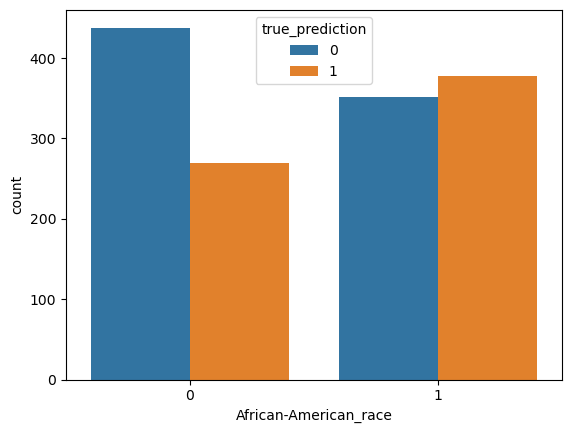

In [39]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='African-American_race', hue = 'true_prediction')

Model Prediction for African Amerian

<AxesSubplot:xlabel='African-American_race', ylabel='count'>

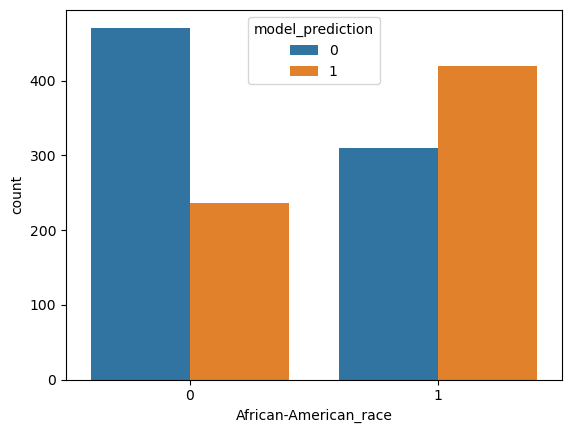

In [40]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='African-American_race', hue = 'model_prediction')

**Note:** We can observe clear bias towards this race

<AxesSubplot:xlabel='Other_race', ylabel='count'>

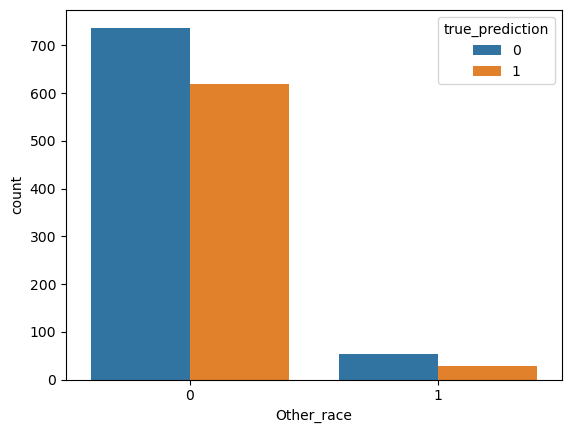

In [41]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='Other_race', hue = 'true_prediction')

<AxesSubplot:xlabel='Other_race', ylabel='count'>

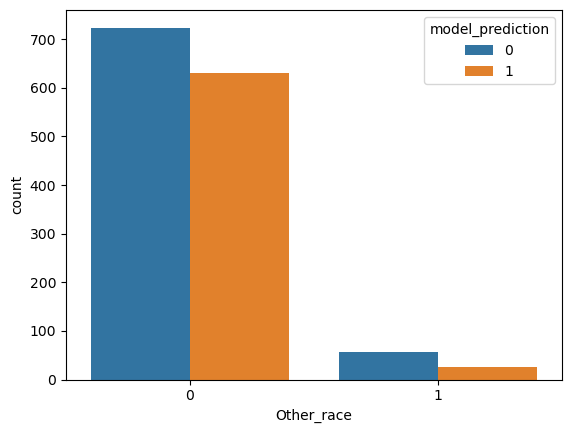

In [42]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='Other_race', hue = 'model_prediction')

This is balanced

<H1>FAIRNESS</H1> 

<h2>Evaluating fairness of the baseline model</h2>

In our case, sensitive attributes are gender and race. Therefore analysing the fairness metrics for these groups on below metrics:

In [43]:
#importing relevant packages related to Fair ML/AI
import aif360
import holisticai
from aif360.datasets import BinaryLabelDataset
# holisticai imports
from holisticai.bias.metrics import classification_bias_metrics
from holisticai.bias.metrics import statistical_parity
from holisticai.bias.metrics import false_positive_rate_diff
from holisticai.bias.metrics import equal_opportunity_diff
from holisticai.bias.metrics import average_odds_diff
from holisticai.bias.metrics import disparate_impact

pip install 'aif360[LawSchoolGPA]'


<h3> We will check bias of baseline model against two sensitve variables sex and race.</h3>

<AxesSubplot:xlabel='sex', ylabel='count'>

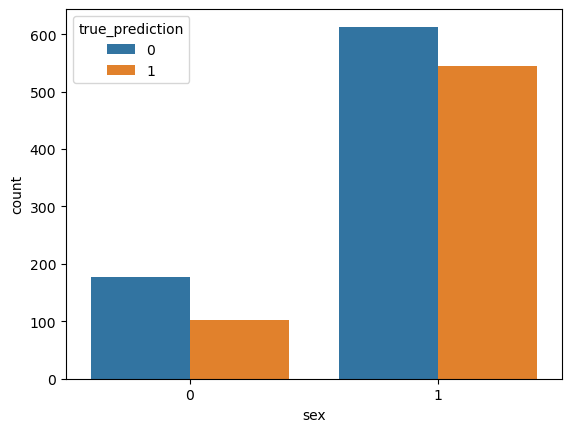

In [44]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='sex', hue = 'true_prediction')

<AxesSubplot:xlabel='sex', ylabel='count'>

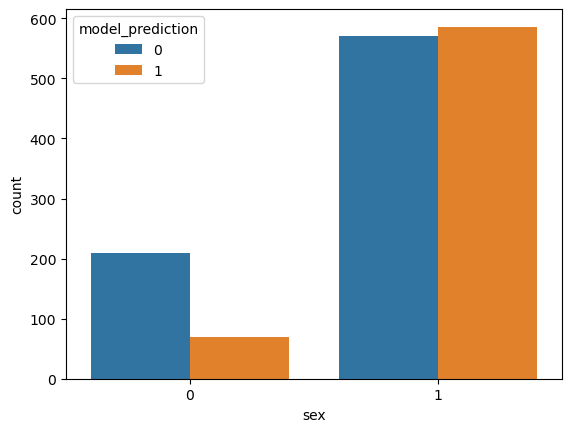

In [45]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='sex', hue = 'model_prediction')

Note: Evident bias against gender male

* checking probability distribution across genders

<Figure size 1000x600 with 0 Axes>

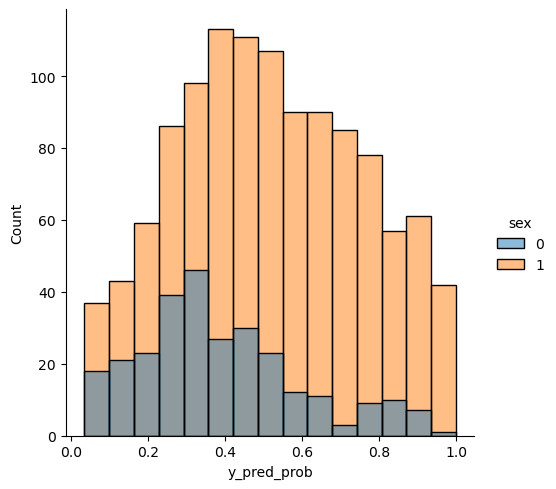

In [46]:
sex_prob_dist_df= pd.merge(predictions_df,X_test['sex'],left_index=True, right_index=True)
plt.figure(figsize=(10,6))
sns.displot(sex_prob_dist_df, x= 'y_pred_prob', hue='sex')

Checking the performance of the baseline model on the below metrics:
1. Statistical Parity : Comparing the Positive Prediction Rate/Precision across groups. i.e. comparing the actual postives against the predicted postives. i.e out of model's postive predictions, how many actually reoffended. A fair model should not have too low of a PPR for sensitive groups since that indicates that model unfairly predicts that many people would reoffend, compred to what aftually did
2. Equal Opportunity : What is the probability that an actual poitive will test positive, i.e. an actual reoffender will be classified as a reoffender? We will compare TPR across groups to compare this. Model should not have too low of a TPR for previledged groups
3. <b>False Positive Rate Disparity : difference across groups in the probability of falsely predicting the reoffence, when they didnt commit one. This will be the metric we will be trying to control going forward, to avoid falsly accusing innocents, and be fair across groups</b> 

<I>Note that the negative values of these metrics are due tot he fact that the metrics are defined considering '1' as 'favorable' outcome and '0' as unfavorable outcome, hence we will be taking negative signs of those and inverting the ratio metrics to keep the results intuitive and inline with thier usual meanings

In [47]:
gender_group_female = X_test['sex'] == 0
gender_group_male = X_test['sex'] == 1

<b>1. Statistical parity:</b>

In [66]:
abs(statistical_parity(gender_group_female,gender_group_male,y_pred_test))

0.25648228176318066

Statistical parity is positive. Meaning the model is biased against gender_group_male. It should be as close to 0 as possible.
We will try to verify it below

In [49]:
positive_pred_sex_df = X_test[X_test['model_prediction'] == 1] #taking positive predictions
Positive_pred_rate_sex_df = positive_pred_sex_df.groupby('sex')['model_prediction','true_prediction'].sum().rename(columns={'model_prediction': 'positive_prediction', 'true_prediction': 'true_prediction'})
Positive_pred_rate_sex_df['PPR'] = Positive_pred_rate_sex_df['true_prediction']/Positive_pred_rate_sex_df['positive_prediction']
Positive_pred_rate_sex_df

,positive_prediction,true_prediction,PPR
sex,,,
0,70,48,0.685714
1,586,385,0.656997


very slight bias in terms of disriminating over gender as per statistical Parity

<b> 2. Equal opportunity : is there differene in Recall across gender groups? That means, out of all the true reoffenders across groups, are we eually likely to predict the chances of reoffence for all the groups? </b>


If we are fair, metric would be 0 , meaning equally likely to predict positive from actual positives across groups. more the deviation, more unfair we are

In [67]:
abs(equal_opportunity_diff(gender_group_female,gender_group_male,y_pred_test,y_test))

0.241701170759566

Model is slightly unfair towards male group. Let us verify by calculating recall across gender groups

In [51]:
positive_act_sex_df = X_test[X_test['true_prediction'] == 1] #taking positive actuals
true_pos_rate_sex_df = positive_act_sex_df.groupby('sex')['model_prediction','true_prediction'].sum().rename(columns={'model_prediction': 'positive_prediction', 'true_prediction': 'true_prediction'})
true_pos_rate_sex_df['TPR'] = true_pos_rate_sex_df['positive_prediction']/true_pos_rate_sex_df['true_prediction']
true_pos_rate_sex_df

,positive_prediction,true_prediction,TPR
sex,,,
0,48,103,0.466019
1,385,544,0.707721


Recall for Males is much much higher than Females

<b>3. False Positive Rate Disparity : Compares FPR, i.e probability of predicting as criminal even when they are not!

In [68]:
abs(false_positive_rate_diff(gender_group_female,gender_group_male,y_pred_test,y_test))

0.2036018101215657

In [53]:
negative_act_sex_df = X_test[X_test['true_prediction'] == 0] #taking negative actuals
fpr_sex_df = negative_act_sex_df.groupby('sex')['model_prediction'].aggregate(['sum','count']).rename(columns={'sum': 'positive_prediction', 'count': 'actual_negatives'})
fpr_sex_df['FPR'] = fpr_sex_df['positive_prediction']/fpr_sex_df['actual_negatives']
fpr_sex_df

,positive_prediction,actual_negatives,FPR
sex,,,
0,22,177,0.124294
1,201,613,0.327896


[Text(0, 0, '0.124294'), Text(0, 0, '0.327896')]

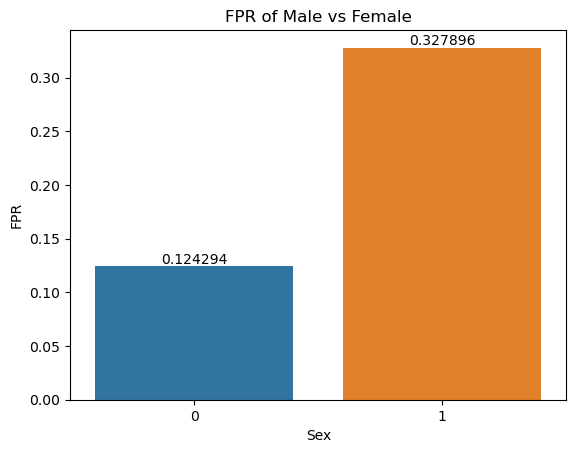

In [54]:
plt.figure()
ax = sns.barplot(x = fpr_sex_df.index, y = fpr_sex_df['FPR'])
plt.title("FPR of Male vs Female")
plt.xlabel("Sex")
plt.ylabel("FPR")
ax.bar_label(ax.containers[0])

Males are more likely to be predicted as reoffenders even when they are not. 

<h3> doing similar analysis for race </h3>

In [55]:
X_test.columns

Index(['id', 'sex', 'age', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'c_charge_desc',
       'time_in_custody_in_days', 'time_in_jail_in_days',
       'African-American_race', 'Asian_race', 'Caucasian_race',
       'Hispanic_race', 'Native American_race', 'Other_race',
       'Felony_c_charge_degree', 'Misdemeanor_c_charge_degree',
       'High_score_text', 'Low_score_text', 'Medium_score_text',
       'High_v_score_text', 'Low_v_score_text', 'Medium_v_score_text',
       'model_prediction', 'true_prediction'],
      dtype='object')

In [56]:
race_df = pd.merge(X_test[['sex','African-American_race','Asian_race','Caucasian_race','Hispanic_race', 'Native American_race', 'Other_race']],predictions_df,left_index=True,right_index=True)
race_df['sex'] =  race_df['sex'].astype("category")
race_df['African-American_race'] =  race_df['African-American_race'].astype("category")
race_df['Asian_race'] = race_df['Asian_race'].astype("category")
race_df['Caucasian_race'] = race_df['Caucasian_race'].astype("category")
race_df['Hispanic_race'] =  race_df['Hispanic_race'].astype("category")
race_df['Native American_race'] =  race_df['Native American_race'].astype("category")
race_df['Other_race'] =  race_df['Other_race'].astype("category")

In [57]:
fairness_eval_race_df = pd.DataFrame(columns=['column','fprd'])


In [58]:
y_pred = race_df['y_pred_labels']
y_true = race_df['y_true_labels']
for col in race_df.columns[0:7]:
	print(col)
	privileged_group = race_df[col] == 0
	unprivileged_group = race_df[col] == 1
	fpr_diff = false_positive_rate_diff(unprivileged_group,privileged_group,y_pred,y_true)
	print(col, fpr_diff)

sex
sex 0.2036018101215657
African-American_race
African-American_race 0.1723614570361146
Asian_race
Asian_race -0.2848020434227331
Caucasian_race
Caucasian_race -0.14079986833443053
Hispanic_race
Hispanic_race -0.042820724817417666
Native American_race
Native American_race 0.2182741116751269
Other_race
Other_race -0.05988069941885765


In [59]:
privileged_group = race_df['African-American_race'] == 0
unprivileged_group = race_df['African-American_race'] == 1
print(equal_opportunity_diff(unprivileged_group,privileged_group,race_df['y_pred_labels'],race_df['y_true_labels']))

0.2165083298912296


<AxesSubplot:xlabel='African-American_race', ylabel='count'>

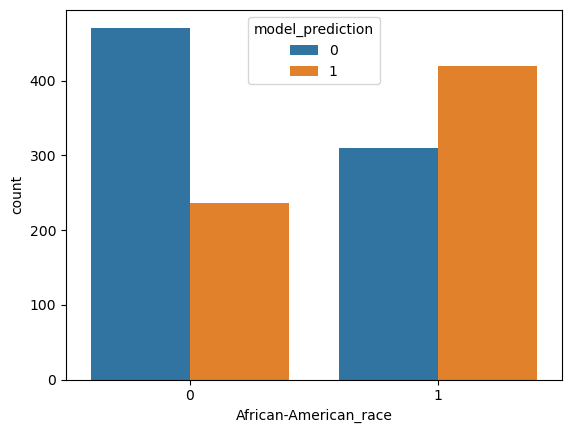

In [60]:
#order = sorted(data[col].unique())
sns.countplot(data=X_test, x='African-American_race', hue = 'model_prediction')

count of unprivileged vs previleged:
 False    1429
True        8
Name: Asian_race, dtype: int64
------------------------------------------------------------
statistical parity :  -0.33336249125262424
equal opportunity diff: 0.3312693498452013
fprd : -0.2848020434227331
dpi : 0.2727099236641221



<Figure size 1000x600 with 0 Axes>

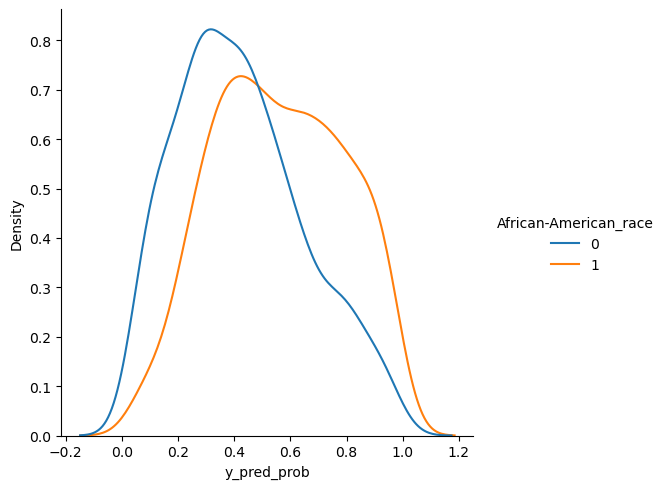

In [61]:
plt.figure(figsize=(10,6))
sns.displot(race_df, x= 'y_pred_prob', hue='African-American_race',kind='kde')
privileged_group = race_df['Asian_race'] == 0
unprivileged_group = race_df['Asian_race'] == 1
y_pred = race_df['y_pred_labels']
y_true = race_df['y_true_labels']
print("count of unprivileged vs previleged:\n",unprivileged_group.value_counts())
print("------------------------------------------------------------")
sp = statistical_parity(unprivileged_group,privileged_group,y_pred)
print("statistical parity : ", sp)
eod = equal_opportunity_diff(unprivileged_group,privileged_group,y_pred,y_true)
print("equal opportunity diff:", eod)
fprd = false_positive_rate_diff(unprivileged_group,privileged_group,y_pred,y_true)
print("fprd :",fprd )
dpi = disparate_impact(unprivileged_group,privileged_group,y_pred)
print("dpi :",dpi )

print()

In [62]:
negative_act_amrace_df = X_test[X_test['true_prediction'] == 0] #taking negative actuals

In [63]:
negative_act_amrace_df = X_test[X_test['true_prediction'] == 0] #taking negative actuals
fpr_am_race_df = negative_act_amrace_df.groupby('African-American_race')['model_prediction'].aggregate(['sum','count']).rename(columns={'sum': 'positive_prediction', 'count': 'actual_negatives'})
fpr_am_race_df['FPR'] = fpr_am_race_df['positive_prediction']/fpr_am_race_df['actual_negatives']
fpr_am_race_df

,positive_prediction,actual_negatives,FPR
African-American_race,,,
0,90,438,0.205479
1,133,352,0.377841


[Text(0, 0, '0.205479'), Text(0, 0, '0.377841')]

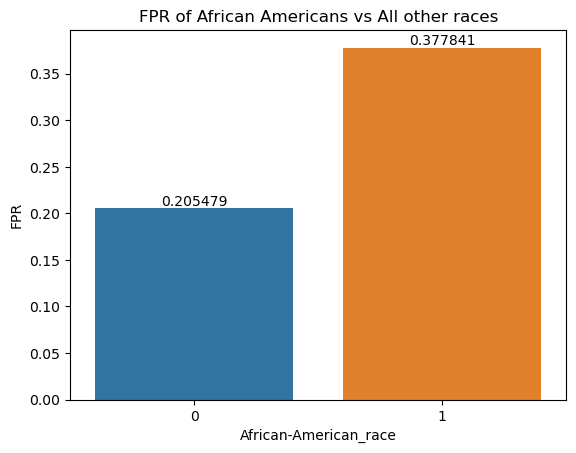

In [64]:
plt.figure()
ax = sns.barplot(x = fpr_am_race_df.index, y = fpr_am_race_df['FPR'])
plt.title("FPR of African Americans vs All other races")
plt.xlabel("African-American_race")
plt.ylabel("FPR")
ax.bar_label(ax.containers[0])

African americans are 16% more likely to be wrongly accused of reoffense

Remarks:
1. FPRs for both gender and African americans is significantly higher compared to previleged groups.
2. As we mititgate this bias, we should expect to see drop in model recall, since we are essentilly reducing the False Positives

<b><h2>  Mitigating the bias

<h4><b>1. In-Processing

- Modifying the data to reduce the bias in the model. 
1. Resampling :  We can resample the minority groups to make representation more fair, but in our case it is not advisable to generate aretififal samples due to the nature of the data and problem statement at hand
2. Reweighting : We will re-weight the data- minority samples in particular to increase their representation. 